In [18]:
import os
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm
from PIL import Image
import gc
import time

# Use Agg backend for headless plotting
matplotlib.use('Agg')

import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold, train_test_split


In [19]:
# Set up parameters
GENRES = [
    "blues", "classical", "country", "disco", "hiphop",
    "jazz", "metal", "pop", "reggae", "rock"
]
SR = 22050
SEGMENT_SECONDS = 5
SEGMENT_SAMPLES = SEGMENT_SECONDS * SR
DATA_ROOT = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
SPEC_ROOT = "./spectrograms"
IMG_SIZE = (224, 224)  # input size for ResNet
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATES = [1e-3, 1e-4]  # Try multiple learning rates
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
K_FOLDS = 5
BEST_MODEL_PATH = "./best_model.pth"

In [20]:
# Optional audio augmentation
def augment_audio(y, sr):
    y = librosa.effects.time_stretch(y, rate=random.uniform(0.9, 1.1))
    y = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.randint(-2, 2))
    y += np.random.normal(0, 0.005, y.shape)
    return y

# Create full-length spectrograms with both original and augmented audio
def generate_spectrograms():
    for genre in GENRES:
        os.makedirs(f"{SPEC_ROOT}/{genre}", exist_ok=True)
        for i in tqdm(range(100), desc=f"{genre:10s}"):
            file_path = os.path.join(DATA_ROOT, "Data", "genres_original", genre, f"{genre}.000{i:02d}.wav")
            try:
                y, _ = librosa.load(file_path, sr=SR)
                if y is None or len(y) == 0:
                    raise ValueError("Empty audio signal")

                for suffix, audio in zip(["orig", "aug"], [y, augment_audio(y.copy(), SR)]):
                    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SR, n_mels=128)
                    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

                    if mel_db.shape[1] == 0:
                        raise ValueError("Empty spectrogram")

                    fig = plt.figure(figsize=(2.24, 2.24), dpi=100)
                    librosa.display.specshow(mel_db, sr=SR, x_axis=None, y_axis=None)
                    plt.axis('off')
                    plt.tight_layout()
                    filename = f"{genre}_{i:02d}_{suffix}.png"
                    out_path = f"{SPEC_ROOT}/{genre}/{filename}"

                    try:
                        plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
                        if os.path.getsize(out_path) == 0:
                            raise IOError("Output PNG file is 0 bytes")
                    except Exception as e:
                        print(f"Error saving {out_path}: {e}")
                    finally:
                        plt.close(fig)
                        plt.cla()
                        plt.clf()
                        gc.collect()
                        time.sleep(0.05)  # allow WSL to breathe

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

In [ ]:
# ResNet-based model for classification
class SpectrogramResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [17]:
# Check for completeness
def should_generate_spectrograms():
    if not os.path.exists(SPEC_ROOT):
        return True
    for genre in GENRES:
        genre_dir = os.path.join(SPEC_ROOT, genre)
        if not os.path.exists(genre_dir) or len([f for f in os.listdir(genre_dir) if f.endswith('.png')]) < 200:
            return True
    return False

if should_generate_spectrograms():
    print("Generating spectrograms...")
    generate_spectrograms()

In [22]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

full_dataset = datasets.ImageFolder(root=SPEC_ROOT, transform=transform)
targets = [full_dataset[i][1] for i in range(len(full_dataset))]
indices = list(range(len(full_dataset)))

train_val_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=targets, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.1, stratify=[targets[i] for i in train_val_idx], random_state=42)

train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_ds = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

best_val_acc = 0.0
best_config = {}

In [23]:
for lr in LEARNING_RATES:
    print(f"\n=== Trying learning rate: {lr} ===")

    model = SpectrogramResNet(num_classes=len(GENRES)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss / len(train_subset):.4f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.2%}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = {'learning_rate': lr}
        torch.save(model.state_dict(), BEST_MODEL_PATH)

print(f"\nBest Config: {best_config}, Best Validation Accuracy: {best_val_acc:.2%}")


=== Trying learning rate: 0.001 ===


/home/rohan/NNDL/music-genre-classifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rohan/NNDL/music-genre-classifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Loss: 1.6974
Epoch 2/30, Loss: 1.1247
Epoch 3/30, Loss: 0.9176
Epoch 4/30, Loss: 0.6444
Epoch 5/30, Loss: 0.4021
Epoch 6/30, Loss: 0.3700
Epoch 7/30, Loss: 0.4113
Epoch 8/30, Loss: 0.2678
Epoch 9/30, Loss: 0.1660
Epoch 10/30, Loss: 0.1092
Epoch 11/30, Loss: 0.0795
Epoch 12/30, Loss: 0.0414
Epoch 13/30, Loss: 0.0402
Epoch 14/30, Loss: 0.1010
Epoch 15/30, Loss: 0.0962
Epoch 16/30, Loss: 0.1590
Epoch 17/30, Loss: 0.1025
Epoch 18/30, Loss: 0.0706
Epoch 19/30, Loss: 0.0537
Epoch 20/30, Loss: 0.0696
Epoch 21/30, Loss: 0.0584
Epoch 22/30, Loss: 0.0434
Epoch 23/30, Loss: 0.0339
Epoch 24/30, Loss: 0.0308
Epoch 25/30, Loss: 0.0269
Epoch 26/30, Loss: 0.0548
Epoch 27/30, Loss: 0.0354
Epoch 28/30, Loss: 0.0460
Epoch 29/30, Loss: 0.0527
Epoch 30/30, Loss: 0.0767
Validation Accuracy: 75.62%

=== Trying learning rate: 0.0001 ===
Epoch 1/30, Loss: 1.6974
Epoch 2/30, Loss: 0.8159
Epoch 3/30, Loss: 0.3548
Epoch 4/30, Loss: 0.1494
Epoch 5/30, Loss: 0.0625
Epoch 6/30, Loss: 0.0441
Epoch 7/30, L

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("\n--- Final Test Evaluation ---")
best_model = SpectrogramResNet(num_classes=len(GENRES)).to(DEVICE)
best_model.load_state_dict(torch.load(BEST_MODEL_PATH))
best_model.eval()

correct, total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {correct / total:.2%}")

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GENRES)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig("confusion_matrix_resnet.png", bbox_inches="tight")



--- Final Test Evaluation ---
Test Accuracy: 78.00%


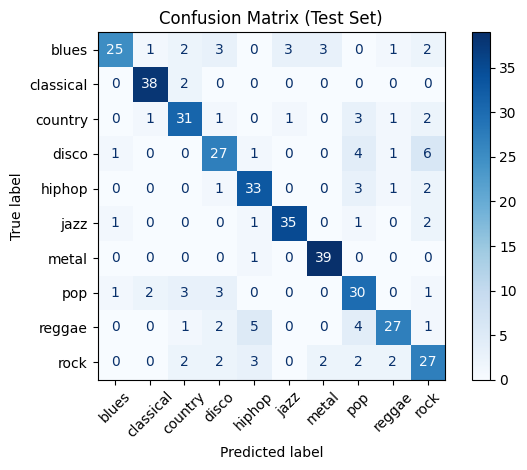

In [27]:
from IPython.display import Image
Image(filename='confusion_matrix_resnet.png')